# Derivative Price Dynamic Delta Hedge Simulation

Delta Hedging Simulation for Quantitative Finance

Initial Option Pricing:
Price: $4.61
Delta: 0.5695
Gamma: 0.039288
Vega: 19.6440

Running hedging simulation with 1000 paths...
=== Delta Hedging Simulation Results ===
Number of simulations: 1000
Mean final hedging error: $-2.5109
Std dev of hedging error: $0.3804
Root Mean Square Error: $2.5396
95% CI of error: [$-3.0628, $-1.5488]


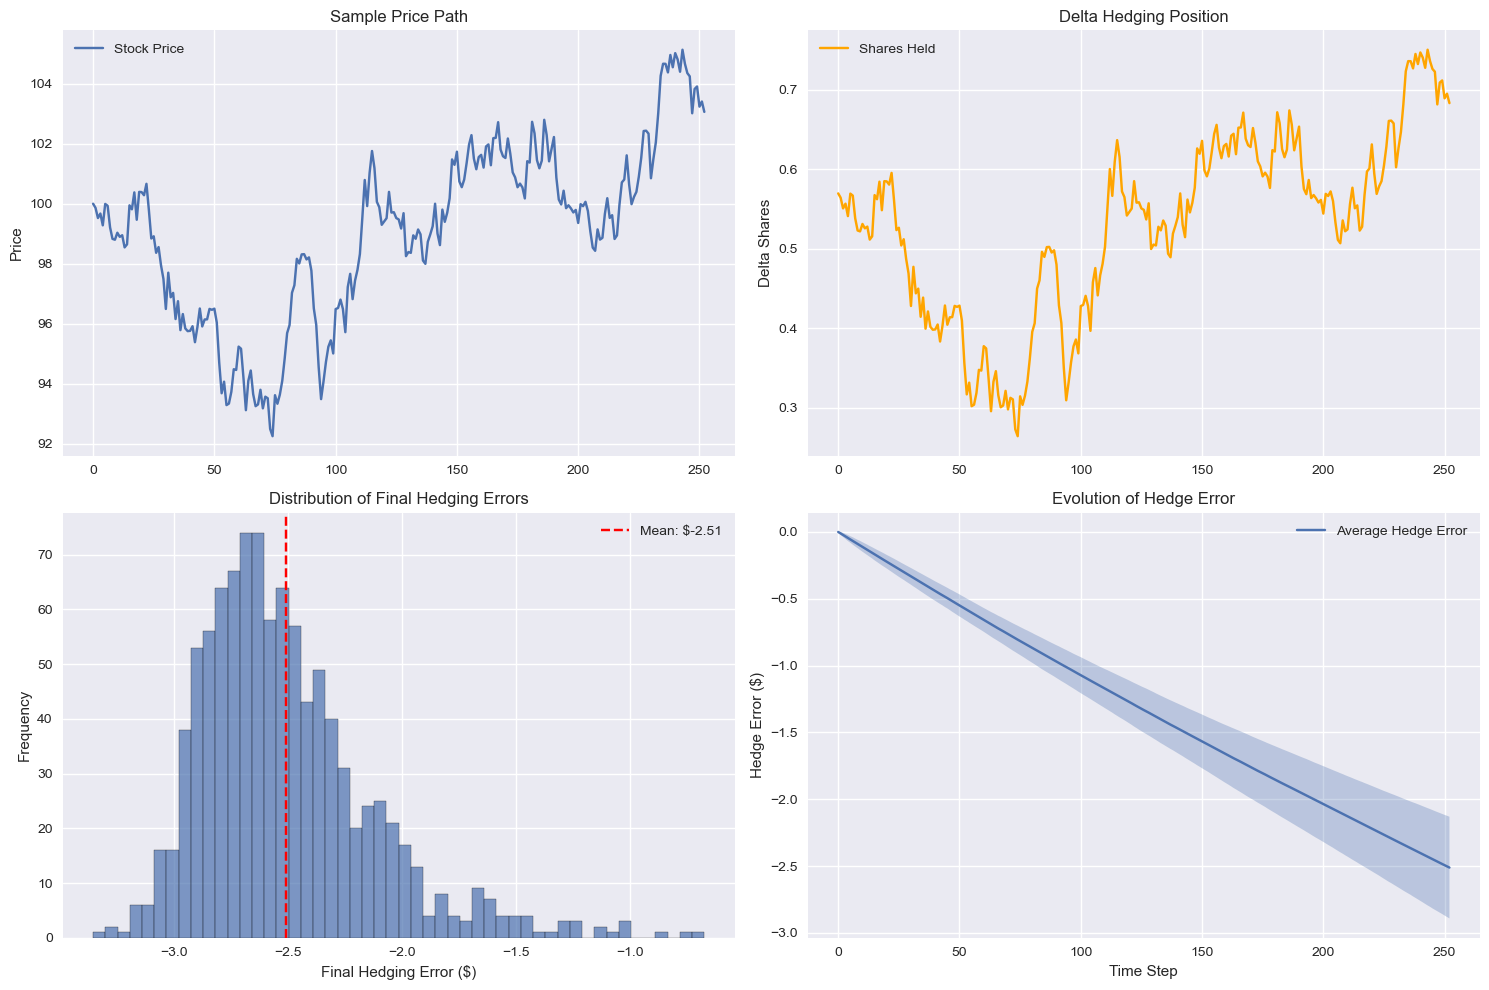


Comparing Hedging Frequencies:
Hedging every 1 days: RMSE = $2.5586
Hedging every 5 days: RMSE = $2.4463
Hedging every 21 days: RMSE = $2.3874

Pricing American option with Monte Carlo...
American call price: $4.58

Portfolio Delta Analysis:
Portfolio Delta (Long Call K=110 + Short Put K=95): 0.4640
Hedge required: 0.4640 shares


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import warnings
warnings.filterwarnings('ignore')

class DeltaHedgingSimulator:
    """
    A comprehensive delta hedging simulator for European and American options
    with transaction cost analysis and performance metrics.
    """
    
    def __init__(self, S0=100, K=100, r=0.05, sigma=0.2, T=0.25, 
                 option_type='call', style='european'):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.option_type = option_type.lower()
        self.style = style.lower()
        self.dt = T / 252  # Daily time steps (trading days)
        self.time_steps = int(T / self.dt)
        
    def black_scholes_price(self, S, calc_greeks=False):
        """Calculate Black-Scholes price and Greeks for European options"""
        if S <= 0:
            if calc_greeks:
                return 0, 0, 0
            return 0
            
        d1 = (np.log(S / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        
        if self.option_type == 'call':
            price = S * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
            delta = norm.cdf(d1)
        else:  # put
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - S * norm.cdf(-d1)
            delta = norm.cdf(d1) - 1
        
        if calc_greeks:
            vega = S * norm.pdf(d1) * np.sqrt(self.T)
            gamma = norm.pdf(d1) / (S * self.sigma * np.sqrt(self.T))
            return price, delta, vega, gamma
        
        return price, delta
    
    def monte_carlo_american_option(self, S0, num_simulations=10000, num_steps=63):
        """Price American options using Monte Carlo with LSM"""
        dt = self.T / num_steps
        Z = np.random.normal(size=(num_simulations, num_steps))
        
        drift = (self.r - 0.5 * self.sigma**2) * dt
        vol = self.sigma * np.sqrt(dt)
        
        log_S = np.log(S0) + np.cumsum(drift + vol * Z, axis=1)
        log_S = np.hstack((np.log(S0)*np.ones((num_simulations, 1)), log_S))
        S_paths = np.exp(log_S)
        
        # Payoff function
        if self.option_type == 'call':
            payoff = np.maximum(S_paths - self.K, 0)
        else:
            payoff = np.maximum(self.K - S_paths, 0)
        
        # LSM algorithm
        value = payoff[:, -1].copy()
        
        for t in range(num_steps-1, 0, -1):
            in_the_money = payoff[:, t] > 0
            if np.sum(in_the_money) > 0:
                X = S_paths[in_the_money, t]
                Y = value[in_the_money] * np.exp(-self.r * dt)
                
                # Quadratic basis regression
                X_basis = np.column_stack([np.ones_like(X), X, X**2])
                coefficients = np.linalg.lstsq(X_basis, Y, rcond=None)[0]
                continuation_value = X_basis @ coefficients
                
                exercise = payoff[in_the_money, t] > continuation_value
                exercise_idx = np.where(in_the_money)[0][exercise]
                value[exercise_idx] = payoff[exercise_idx, t]
                
                # Discount non-exercised paths
                non_exercise_idx = np.where(in_the_money)[0][~exercise]
                value[non_exercise_idx] = value[non_exercise_idx] * np.exp(-self.r * dt)
        
        return np.mean(value * np.exp(-self.r * dt))
    
    def calculate_greeks_finite_difference(self, S, epsilon=0.01, epsilon_vol=0.001):
        """Calculate Greeks using finite difference methods"""
        # Delta
        price_up, _ = self.black_scholes_price(S + epsilon)
        price_down, _ = self.black_scholes_price(S - epsilon)
        delta = (price_up - price_down) / (2 * epsilon)
        
        # Gamma
        gamma = (price_up - 2 * self.black_scholes_price(S)[0] + price_down) / (epsilon**2)
        
        # Vega
        original_sigma = self.sigma
        self.sigma = original_sigma + epsilon_vol
        price_vol_up, _ = self.black_scholes_price(S)
        self.sigma = original_sigma - epsilon_vol
        price_vol_down, _ = self.black_scholes_price(S)
        self.sigma = original_sigma
        vega = (price_vol_up - price_vol_down) / (2 * epsilon_vol)
        
        return delta, gamma, vega
    
    def generate_price_path(self, mu=None, num_paths=1):
        """Generate stock price paths using Geometric Brownian Motion"""
        if mu is None:
            mu = self.r
            
        dt = self.dt
        n_steps = self.time_steps
        
        # Generate paths
        paths = np.zeros((num_paths, n_steps + 1))
        paths[:, 0] = self.S0
        
        for i in range(1, n_steps + 1):
            z = np.random.normal(size=num_paths)
            paths[:, i] = paths[:, i-1] * np.exp((mu - 0.5 * self.sigma**2) * dt + 
                                                self.sigma * np.sqrt(dt) * z)
        
        return paths
    
    def run_hedging_simulation(self, hedging_frequency=1, transaction_cost=0.0005, 
                              num_simulations=1000, mu=None):
        """Run complete delta hedging simulation"""
        results = []
        
        for sim in range(num_simulations):
            # Generate price path
            price_path = self.generate_price_path(mu=mu, num_paths=1)[0]
            
            # Initialize tracking arrays
            portfolio_value = np.zeros(len(price_path))
            cash_account = np.zeros(len(price_path))
            shares_held = np.zeros(len(price_path))
            hedge_error = np.zeros(len(price_path))
            
            # Initial option price and delta
            initial_price, initial_delta = self.black_scholes_price(price_path[0])
            
            # Sell option, receive premium
            cash_account[0] = initial_price
            shares_held[0] = initial_delta
            cash_account[0] -= shares_held[0] * price_path[0]  # Buy initial hedge
            
            # Store initial portfolio value
            portfolio_value[0] = -initial_price + shares_held[0] * price_path[0] + cash_account[0]
            
            for t in range(1, len(price_path)):
                if t % hedging_frequency != 0 and t != len(price_path)-1:
                    # No rebalancing on this day
                    shares_held[t] = shares_held[t-1]
                    cash_account[t] = cash_account[t-1] * np.exp(self.r * self.dt)
                    portfolio_value[t] = shares_held[t] * price_path[t] + cash_account[t]
                    continue
                
                # Calculate current delta
                current_price, current_delta = self.black_scholes_price(price_path[t])
                
                # Shares needed for hedge
                shares_needed = current_delta
                shares_to_trade = shares_needed - shares_held[t-1]
                
                # Transaction costs
                trade_cost = abs(shares_to_trade) * price_path[t] * transaction_cost
                
                # Update cash account (include interest and transaction costs)
                cash_account[t] = cash_account[t-1] * np.exp(self.r * self.dt) - \
                                 shares_to_trade * price_path[t] - trade_cost
                
                shares_held[t] = shares_needed
                
                # Calculate portfolio value
                portfolio_value[t] = shares_held[t] * price_path[t] + cash_account[t] - current_price
                
                # Hedge error (should be close to 0 in perfect world)
                hedge_error[t] = portfolio_value[t]
            
            results.append({
                'price_path': price_path,
                'portfolio_value': portfolio_value,
                'cash_account': cash_account,
                'shares_held': shares_held,
                'hedge_error': hedge_error,
                'final_error': hedge_error[-1]
            })
        
        return results
    
    def analyze_results(self, results):
        """Analyze and visualize hedging results"""
        final_errors = [r['final_error'] for r in results]
        
        print("=== Delta Hedging Simulation Results ===")
        print(f"Number of simulations: {len(results)}")
        print(f"Mean final hedging error: ${np.mean(final_errors):.4f}")
        print(f"Std dev of hedging error: ${np.std(final_errors):.4f}")
        print(f"Root Mean Square Error: ${np.sqrt(np.mean(np.array(final_errors)**2)):.4f}")
        print(f"95% CI of error: [${np.percentile(final_errors, 2.5):.4f}, ${np.percentile(final_errors, 97.5):.4f}]")
        
        # Plot results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot sample price path and delta
        sample_result = results[0]
        axes[0,0].plot(sample_result['price_path'], label='Stock Price')
        axes[0,0].set_ylabel('Price')
        axes[0,0].set_title('Sample Price Path')
        axes[0,0].legend()
        
        axes[0,1].plot(sample_result['shares_held'], label='Shares Held', color='orange')
        axes[0,1].set_ylabel('Delta Shares')
        axes[0,1].set_title('Delta Hedging Position')
        axes[0,1].legend()
        
        # Plot hedge error distribution
        axes[1,0].hist(final_errors, bins=50, alpha=0.7, edgecolor='black')
        axes[1,0].axvline(np.mean(final_errors), color='red', linestyle='--', label=f'Mean: ${np.mean(final_errors):.2f}')
        axes[1,0].set_xlabel('Final Hedging Error ($)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Distribution of Final Hedging Errors')
        axes[1,0].legend()
        
        # Plot cumulative hedge error
        time_points = np.arange(len(sample_result['hedge_error']))
        avg_hedge_error = np.mean([r['hedge_error'] for r in results], axis=0)
        axes[1,1].plot(time_points, avg_hedge_error, label='Average Hedge Error')
        axes[1,1].fill_between(time_points, 
                              avg_hedge_error - np.std([r['hedge_error'] for r in results], axis=0),
                              avg_hedge_error + np.std([r['hedge_error'] for r in results], axis=0),
                              alpha=0.3)
        axes[1,1].set_xlabel('Time Step')
        axes[1,1].set_ylabel('Hedge Error ($)')
        axes[1,1].set_title('Evolution of Hedge Error')
        axes[1,1].legend()
        
        plt.tight_layout()
        plt.savefig('delta_hedging_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return {
            'mean_error': np.mean(final_errors),
            'std_error': np.std(final_errors),
            'rmse': np.sqrt(np.mean(np.array(final_errors)**2)),
            'confidence_interval': [np.percentile(final_errors, 2.5), np.percentile(final_errors, 97.5)]
        }

def main():
    """Main demonstration function"""
    print("Delta Hedging Simulation for Quantitative Finance")
    print("=" * 50)
    
    # Initialize simulator
    simulator = DeltaHedgingSimulator(
        S0=100,
        K=100,
        r=0.05,
        sigma=0.2,
        T=0.25,  # 3 months
        option_type='call',
        style='european'
    )
    
    # Calculate initial Greeks
    price, delta, vega, gamma = simulator.black_scholes_price(simulator.S0, calc_greeks=True)
    print(f"\nInitial Option Pricing:")
    print(f"Price: ${price:.2f}")
    print(f"Delta: {delta:.4f}")
    print(f"Gamma: {gamma:.6f}")
    print(f"Vega: {vega:.4f}")
    
    # Run hedging simulation
    print(f"\nRunning hedging simulation with 1000 paths...")
    results = simulator.run_hedging_simulation(
        hedging_frequency=1,  # Daily hedging
        transaction_cost=0.0005,  # 5 basis points transaction cost
        num_simulations=1000
    )
    
    # Analyze results
    metrics = simulator.analyze_results(results)
    
    # Compare different hedging frequencies
    print(f"\nComparing Hedging Frequencies:")
    frequencies = [1, 5, 21]  # Daily, weekly, monthly
    performance = {}
    
    for freq in frequencies:
        results_freq = simulator.run_hedging_simulation(
            hedging_frequency=freq,
            transaction_cost=0.0005,
            num_simulations=500
        )
        final_errors = [r['final_error'] for r in results_freq]
        performance[freq] = {
            'mean_error': np.mean(final_errors),
            'rmse': np.sqrt(np.mean(np.array(final_errors)**2)),
            'std_error': np.std(final_errors)
        }
        print(f"Hedging every {freq} days: RMSE = ${performance[freq]['rmse']:.4f}")
    
    # Compare with American option
    print(f"\nPricing American option with Monte Carlo...")
    american_price = simulator.monte_carlo_american_option(simulator.S0)
    print(f"American {simulator.option_type} price: ${american_price:.2f}")
    
    # Portfolio analysis example
    print(f"\nPortfolio Delta Analysis:")
    # Create a portfolio: Long call + Short put
    call_sim = DeltaHedgingSimulator(S0=100, K=110, r=0.05, sigma=0.2, T=0.25, option_type='call')
    put_sim = DeltaHedgingSimulator(S0=100, K=95, r=0.05, sigma=0.2, T=0.25, option_type='put')
    
    _, call_delta = call_sim.black_scholes_price(100)
    _, put_delta = put_sim.black_scholes_price(100)
    
    portfolio_delta = call_delta + (-put_delta)  # Long call + Short put
    print(f"Portfolio Delta (Long Call K=110 + Short Put K=95): {portfolio_delta:.4f}")
    print(f"Hedge required: {portfolio_delta:.4f} shares")

if __name__ == "__main__":
    main()

In [7]:
class RealisticDeltaHedgingSimulator:

    
    def __init__(self, ticker='AAPL', strike=150, expiration_date='2024-06-21', 
                 risk_free_rate_source='^IRX', historical_vol_days=30):

        self.ticker = ticker
        self.strike = strike
        self.expiration_date = expiration_date
        self.risk_free_rate_source = risk_free_rate_source
        
        # These would be fetched from a data API in a real application
        self.S0 = self._fetch_current_price(ticker)
        self.r = self._fetch_risk_free_rate(risk_free_rate_source)
        self.T = self._calculate_time_to_expiry(expiration_date)
        self.sigma = self._calculate_historical_volatility(ticker, historical_vol_days)
        
        print(f"Initialized simulator for {ticker}")
        print(f"  Current Price (S0): ${self.S0:.2f}")
        print(f"  Risk-Free Rate (r): {self.r:.4%}")
        print(f"  Time to Expiry (T): {self.T:.2f} years")
        print(f"  Historical Volatility (σ): {self.sigma:.2%}")

    def _fetch_current_price(self, ticker):
        """Placeholder function: In reality, connects to Bloomberg, Yahoo Finance, etc."""
        # Simulate a real price fetch. A real function would use an API.
        # Let's pretend AAPL is trading at $172.50
        simulated_prices = {'AAPL': 172.50, 'MSFT': 415.22, 'GOOGL': 150.75}
        return simulated_prices.get(ticker, 100.0) # default to 100 if ticker not found

    def _fetch_risk_free_rate(self, source):
        """Placeholder function: Fetches a proxy risk-free rate."""
        # Simulate fetching the 13-week treasury yield (^IRX)
        # ^IRX is quoted as 5.25, but it's actually 5.25%
        simulated_rates = {'^IRX': 0.0525, '^TYX': 0.0420}
        return simulated_rates.get(source, 0.05) # default to 5%

    def _calculate_time_to_expiry(self, exp_date):
        """Calculates time to expiry in years."""
        from datetime import datetime
        expiry = datetime.strptime(exp_date, '%Y-%m-%d')
        now = datetime.now()
        days_to_expiry = (expiry - now).days
        return days_to_expiry / 365.25 # Convert days to years

    def _calculate_historical_volatility(self, ticker, lookback_days):
        """Placeholder: Calculates historical volatility from past prices."""
        # In reality, you'd fetch historical data and calculate log returns.
        # Let's simulate some realistic volatilities.
        simulated_vols = {'AAPL': 0.22, 'MSFT': 0.18, 'GOOGL': 0.25, 'TSLA': 0.55}
        return simulated_vols.get(ticker, 0.2) # default to 20%

# --- Usage Example ---
print("### Realistic Simulator Demo ###")
real_simulator = RealisticDeltaHedgingSimulator(
    ticker='AAPL',
    strike=175,
    expiration_date='2024-06-21',
    risk_free_rate_source='^IRX',
    historical_vol_days=30
)

### Realistic Simulator Demo ###
Initialized simulator for AAPL
  Current Price (S0): $172.50
  Risk-Free Rate (r): 5.2500%
  Time to Expiry (T): -1.22 years
  Historical Volatility (σ): 22.00%
